# Import all necessary python packages

In [1]:
# Howard Wang 05/14/19
# CSE 145: Embedded systems and design

# Main Database: https://surf.smartfin.org/

# Analyzing data from Buoy Calibration experiment to get wave direction.
# First, parse the data from the .CSV file containing ocean and wave motion data.
# This data comes from a controlled experiment (CE3), so we are assuming that 
# all of the vertical accelerations are contained in IMUA2.

# MATPLOTLIB
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

#from mpl_toolkits.basemap import Basemap

# DATAFRAMES
import pandas as pd
import numpy as np

# SCIPY
from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
import pylab as pylab

# SYSTEM and CONVERSION TOOLS
import math
import abc
import sys
import csv
import io
import os
import datetime
import pytz
import re

# MODELING AND GRAPHS
import peakutils
import statsmodels.api as sm

# URL REQUESTS
import requests

# VECTORS AND GRAPHICS
import mpld3
import folium
# import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

# PLOTTING TOOLS
from plotly import tools 
import plotly.offline
import plotly.graph_objs as go

%matplotlib notebook
%matplotlib inline

print("Done!")

Done!


# Use recent buoy-float ride (*16083*)

In [2]:
ride_ids = ['16083'] 
# This is the recent (May 15th buoy float session ID)
# A smartfin was placed next to a real buoy and data was collected
# Now data must be scrutinized against buoy float data
print("Done!")

Done!


# Scrape motion and ocean csv data from smartfin database

In [3]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        oceanCSV = requests.get(ocean_csv_url).content
        ocean_df_small = pd.read_csv(io.StringIO(oceanCSV.decode('utf-8')))

        # Grab CSV from motion url
        motionCSV = requests.get(motion_csv_url).content
        motion_df_small = pd.read_csv(io.StringIO(motionCSV.decode('utf-8')))
        
        return ocean_df_small, motion_df_small

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample

print("Done!")

Done!


# Print out both dataframes

In [4]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])

# Print motion and Ocean dataframes
print(motion_df)
print(ocean_df)

https://surf.smartfin.org/ride/16083
https://surf.smartfin.org/media/201905/google_105349665704999793400_0006667E229D_190515161151_Ocean.CSV
Ride data has been uploaded.
                                         UTC       Time  IMU A1  IMU A2  \
ride_id                                                                   
16083   0     2019-05-15T16:11:51.2410+00:00  762168371   -59.0   505.0   
        1     2019-05-15T16:11:51.4940+00:00  762168623   -56.0   493.0   
        2     2019-05-15T16:11:51.7460+00:00  762168873   -60.0   524.0   
        3     2019-05-15T16:11:51.9990+00:00  762169125   -58.0   551.0   
        4     2019-05-15T16:11:52.2510+00:00  762169375   -57.0   519.0   
        5     2019-05-15T16:11:52.5030+00:00  762169625   -56.0   450.0   
        6     2019-05-15T16:11:52.7540+00:00  762169875   -57.0   439.0   
        7     2019-05-15T16:11:53.0070+00:00  762170126   -56.0   497.0   
        8     2019-05-15T16:11:53.2580+00:00  762170376   -59.0   506.0   
     

                                        UTC       Time  Temperature 1  \
ride_id                                                                 
16083   0    2019-05-15T16:11:50.7700+00:00  762167903            303   
        1    2019-05-15T16:11:56.8280+00:00  762173923            303   
        2    2019-05-15T16:12:02.8860+00:00  762179942            303   
        3    2019-05-15T16:12:08.9450+00:00  762185962            303   
        4    2019-05-15T16:12:15.0030+00:00  762191982            303   
        5    2019-05-15T16:12:21.0620+00:00  762198002            303   
        6    2019-05-15T16:12:27.1200+00:00  762204021            303   
        7    2019-05-15T16:12:33.1780+00:00  762210041            303   
        8    2019-05-15T16:12:39.2360+00:00  762216060            303   
        9    2019-05-15T16:12:45.2950+00:00  762222080            303   
        10   2019-05-15T16:12:51.3540+00:00  762228101            303   
        11   2019-05-15T16:12:57.4130+00:00  762234

## Make copy of motion data

In [5]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 
                                            'IMU M2', 'IMU M3'])
print(dropped_motion_df)

                                         UTC       Time  IMU A1  IMU A2  \
ride_id                                                                   
16083   0     2019-05-15T16:11:51.2410+00:00  762168371   -59.0   505.0   
        1     2019-05-15T16:11:51.4940+00:00  762168623   -56.0   493.0   
        2     2019-05-15T16:11:51.7460+00:00  762168873   -60.0   524.0   
        3     2019-05-15T16:11:51.9990+00:00  762169125   -58.0   551.0   
        4     2019-05-15T16:11:52.2510+00:00  762169375   -57.0   519.0   
        5     2019-05-15T16:11:52.5030+00:00  762169625   -56.0   450.0   
        6     2019-05-15T16:11:52.7540+00:00  762169875   -57.0   439.0   
        7     2019-05-15T16:11:53.0070+00:00  762170126   -56.0   497.0   
        8     2019-05-15T16:11:53.2580+00:00  762170376   -59.0   506.0   
        9     2019-05-15T16:11:53.5110+00:00  762170627   -57.0   501.0   
        10    2019-05-15T16:11:53.7630+00:00  762170877   -59.0   499.0   
        11    2019-05-15T

# Calculate time offsets, and normalize columns

In [6]:
# To store time elapsed between each measurement, and time offset from 0s
time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []
imuA1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array_A1 = []
imuA2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array_A2 = []
imuA3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array_A3 = []
imuG1_array_nans = np.array(dropped_motion_df.loc[:,"IMU G1"], dtype=float)
imu_array_G1 = []
imuG2_array_nans = np.array(dropped_motion_df.loc[:,"IMU G2"], dtype=float)
imu_array_G2 = []
imuG3_array_nans = np.array(dropped_motion_df.loc[:,"IMU G3"], dtype=float)
imu_array_G3 = []
imuM1_array_nans = np.array(dropped_motion_df.loc[:,"IMU M1"], dtype=float)
imu_array_M1 = []
imuM2_array_nans = np.array(dropped_motion_df.loc[:,"IMU M2"], dtype=float)
imu_array_M2 = []
imuM3_array_nans = np.array(dropped_motion_df.loc[:,"IMU M3"], dtype=float)
imu_array_M3 = []


#Get all the times and imus where time, imu a1, imu a2, and imu a3 are NOT nan values:
for t,x,y,z,a,b,c,d,e,f in zip(time_array_nans, imuA1_array_nans, imuA2_array_nans, imuA3_array_nans, imuG1_array_nans, 
                              imuG2_array_nans, imuG3_array_nans, imuM1_array_nans, imuM2_array_nans, imuM3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array_A1.append(x)
        imu_array_A2.append(y)
        imu_array_A3.append(z)
        imu_array_G1.append(a)
        imu_array_G2.append(b)
        imu_array_G3.append(c)
        imu_array_M1.append(d)
        imu_array_M2.append(e)
        imu_array_M3.append(f)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1

##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array_A1[-1])
del(imu_array_A2[-1])
del(imu_array_A3[-1])
del(imu_array_G1[-1])
del(imu_array_G2[-1])
del(imu_array_G3[-1])
del(imu_array_M1[-1])
del(imu_array_M2[-1])
del(imu_array_M3[-1])
    
print(len(time_e_list))
print(len(time_o_list))
print(len(imu_array_A1))
print(len(imu_array_A2))
print(len(imu_array_A3))
print(len(imu_array_G1))
print(len(imu_array_G2))
print(len(imu_array_G3))
print(len(imu_array_M1))
print(len(imu_array_M2))
print(len(imu_array_M3))
CheckLength = len(time_e_list) + len(time_o_list) + len(imu_array_A1) + len(imu_array_A2) + len(imu_array_A3) + len(imu_array_G1) + len(imu_array_G2) + len(imu_array_G3) + len(imu_array_M1)+ len(imu_array_M2) + len(imu_array_M3)

if CheckLength//11 == len(time_e_list):
    print("All columns are matching!")

6202
6202
6202
6202
6202
6202
6202
6202
6202
6202
6202
All columns are matching!


# Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

In [7]:
#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = 9.80665

# Correct the IMU Acceleration columns into units of meters
def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array_A1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array_A2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array_A3) #new units in m/s^2

# To check:
#for x,y in zip(imu2_array, imu_array_A2):
#   print(x,y)
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

# To check:
# for t in time_e_array:
#    print(t)
print("Done!")

Done!


# Calculate and plot magnitude of acceleration on X plane

Graph of X Acceleration vs. Time


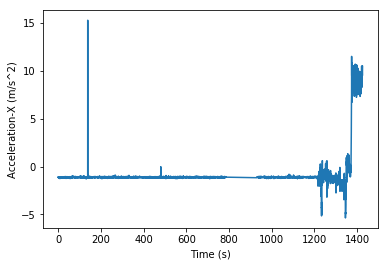

In [8]:
print("Graph of X Acceleration vs. Time")

plt.plot(time_e_array, imu1_array)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration-X (m/s^2)")
plt.show()

# Center and Calibrate Magnetometer Data

In [9]:
# Offset variables help in recentering the magnetic data in order to define direction and use trig functions
M1_offset_var = 219.786
M2_offset_var = 180
M3_offset_var = 280

def calibrate_magn_data(magn_array, offset_value):
    ret_array = []
    for m in magn_array:
        new_m = m - offset_value
        ret_array.append(new_m)
    return ret_array

imuM1_array = calibrate_magn_data(imu_array_M1, M1_offset_var)
imuM2_array = calibrate_magn_data(imu_array_M2, M2_offset_var)
imuM3_array = calibrate_magn_data(imu_array_M3, M3_offset_var)

# Check 
# print(imuM1_array)
print("Done.")

Done.


# Set up 3xN arrays for Magnetometer and Accel values 

In [10]:
# Create N x 3 arrays for functions that need them later on, such as Scikit Kinematics
magn_height = len(imuM1_array)
acc_height = len(imu1_array)

acc_array = np.zeros(shape=(acc_height,3))
magn_array = np.zeros(shape=(magn_height,3))

print("For Accelerometer: ")
for x in range(len(acc_array)):
    acc_array[x,0] = imu1_array[x]
    acc_array[x,1] = imu2_array[x]
    acc_array[x,2] = imu3_array[x]
print(acc_array)

print("\nFor Magnetometer: ")
for x in range(len(magn_array)):
    magn_array[x,0] = imuM1_array[x]
    magn_array[x,1] = imuM2_array[x]
    magn_array[x,2] = imuM3_array[x]

print(magn_array)
print("Done.")

For Accelerometer: 
[[-1.13006318  9.67257471  1.20667764]
 [-1.07260234  9.44273135  1.18752402]
 [-1.1492168  10.03649336  1.66636436]
 ...
 [ 9.97903252 -0.55545479  1.85790049]
 [ 9.99818613 -0.42137949  2.06859023]
 [ 9.55765303 -0.32561143  1.85790049]]

For Magnetometer: 
[[-190.786 -325.     -83.   ]
 [-207.786 -328.     -86.   ]
 [-203.786 -330.     -92.   ]
 ...
 [-488.786  -61.    -379.   ]
 [-485.786  -60.    -380.   ]
 [-474.786  -59.    -373.   ]]
Done.


# Conversion from fin-frame to board-frame

Orientation from here onwards will be from the board/surfers reference frame (yaw left = turning left)

x = -IMU1, y = -IMU3, z = -IMU2

In [11]:
# The new array for board reference frame will have the IMUs in columns according to X,Y,Z directions
print("For Accelerometer:")
board_acc = acc_array.copy()       # Reassign to the correct axes as stated above
temp_x_acc = board_acc[:,0] * (-1)
temp_y_acc = board_acc[:,1] * (-1)
temp_z_acc = board_acc[:,2] * (-1)
board_acc[:,0] = temp_x_acc     # X acceleration
board_acc[:,1] = temp_y_acc     # Y acceleration
board_acc[:,2] = temp_z_acc     # Z acceleration
print(board_acc)

print("\nFor Magnetometer:")
board_magn = magn_array.copy()
temp_x_magn = board_magn[:,0] * (-1)
temp_y_magn = board_magn[:,1] * (-1)
temp_z_magn = board_magn[:,2] * (-1)
board_magn[:,0] = temp_x_magn
board_magn[:,1] = temp_y_magn
board_magn[:,2] = temp_z_magn
print(board_magn)
print("Done.")

For Accelerometer:
[[  1.13006318  -9.67257471  -1.20667764]
 [  1.07260234  -9.44273135  -1.18752402]
 [  1.1492168  -10.03649336  -1.66636436]
 ...
 [ -9.97903252   0.55545479  -1.85790049]
 [ -9.99818613   0.42137949  -2.06859023]
 [ -9.55765303   0.32561143  -1.85790049]]

For Magnetometer:
[[190.786 325.     83.   ]
 [207.786 328.     86.   ]
 [203.786 330.     92.   ]
 ...
 [488.786  61.    379.   ]
 [485.786  60.    380.   ]
 [474.786  59.    373.   ]]
Done.


# Azimuth and altitude calculations

In [12]:
# Azimuth and Altitude LEGEND:
# Altitude is the angle between the ground and the vector 
# Azimuth is the angle going clockwise from 0 deg North:
# N - 0/360deg, E - 90deg, S - 180deg, W - 270deg

# This will get complicated (ie make cases or lots of if statements) when rotations about the heading become more prevalent
def azimuth(x,y,z):
    real_y = y * (-1) # This is to account for y 
    return (180/math.pi * math.atan2(real_y,x)) % 360

def altitude(x,y,z):
    h = math.hypot(y, x)
    return 180/math.pi * math.atan2(z,h)

def printAltAzi(alt, azi):
    print ("Alt:", alt, "\n", "Azi:",azi,"\n")
# These values are uncorrected values: still need to add or subtract 'declination'
#     (for AziMuth) and 'inclination' (for Altitude) correction values for geographical location

heading_altitude = board_magn[:,0].copy()
heading_azimuth = board_magn[:,0].copy()

i = 0     #iterator
#for i in range(len(M1_no_out)):
while i < len(heading_altitude):
    factor = 0;
    # Use acceleration values to calibrate magnetometer
    if (board_acc[i, 0] >= 0):
        factor = 1
    else:
        factor = -1
    
    heading_altitude[i] = altitude(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    heading_azimuth[i] = azimuth(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    heading_azimuth[i] = heading_azimuth[i] * factor
    
    #printAltAzi(heading_altitude[i],heading_azimuth[i])
    i += 1

#for t in range(len(time_e_array)):
    #printAltAzi(heading_altitude[t], heading_azimuth[t])

# Plot polar azimuth and altitude

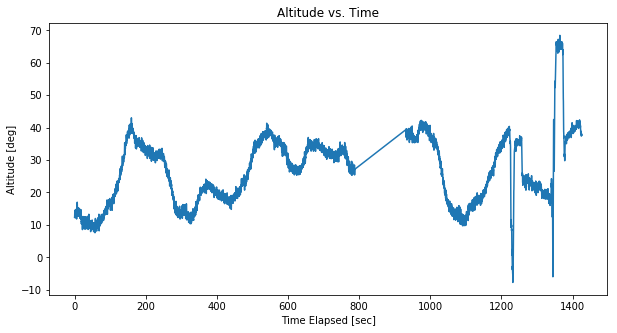

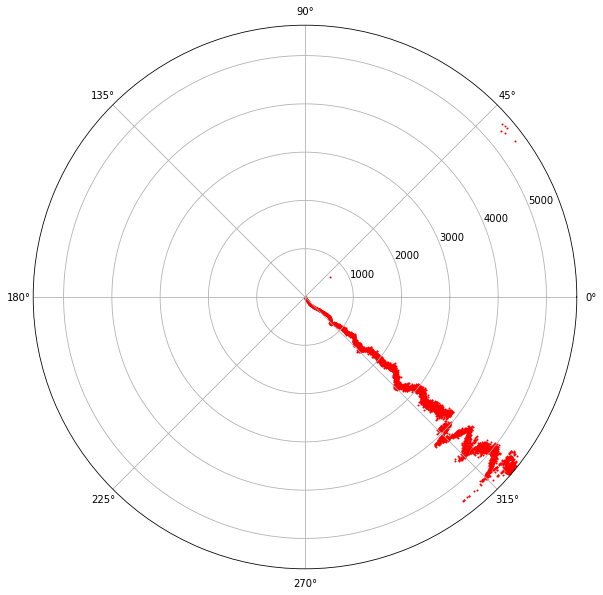

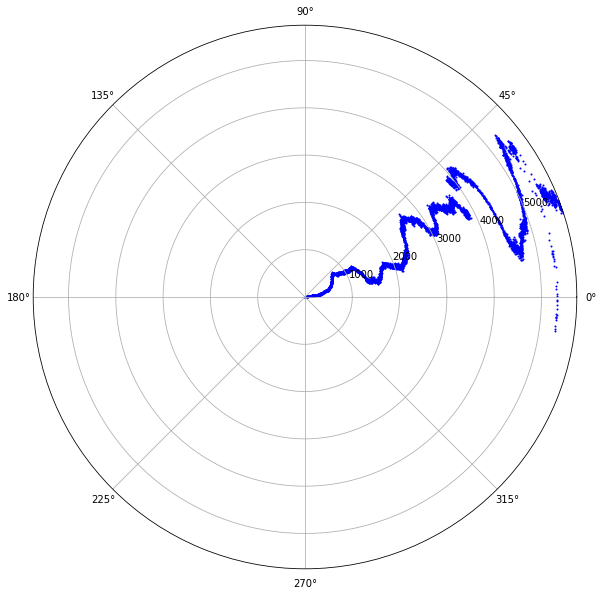

In [13]:
# Fixing random state for reproducibility
heading_alt_plot = plt.figure(figsize=(10,5))
alt_plot = heading_alt_plot.add_subplot(111)
alt_plot.plot(time_e_array, heading_altitude)
alt_plot.set_title("Altitude vs. Time")
alt_plot.set_xlabel("Time Elapsed [sec]")
alt_plot.set_ylabel("Altitude [deg]")
plt.show()

np.random.seed(19680801)

# Compute areas and colors
r = [i for i in range(0, len(board_magn))]
theta = heading_azimuth/360 * 2 * np.pi
area = 1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c='red', s=area, cmap='hsv', alpha=1)

# Compute areas and colors
alt_r = [i for i in range(0, len(board_magn))]
alt_theta = heading_altitude/360 * 2 * np.pi
alt_area = 1
alt_colors = theta

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111, projection='polar')
c2 = ax2.scatter(alt_theta, alt_r, c='blue', s=alt_area, cmap='hsv', alpha=1)

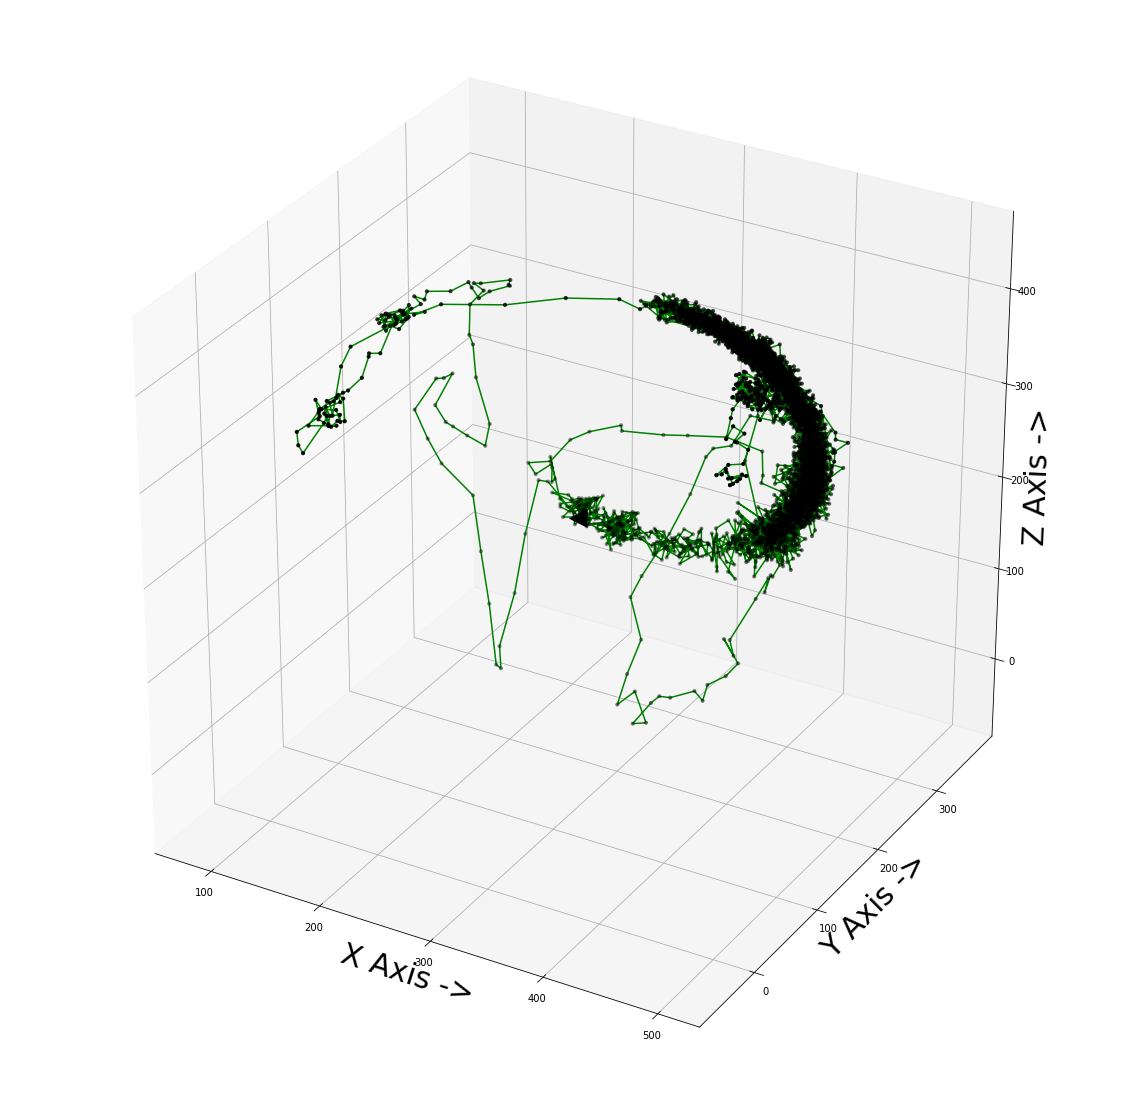

In [14]:
# Plot first 10 directional changes 
magnfig = plt.figure(figsize=(20,20))
magnaxi = magnfig.add_subplot(111, projection='3d')
magnaxi.scatter(board_magn[0,0], board_magn[0,1], board_magn[0,2], c='black', s=300, marker = "<")
magnaxi.scatter(board_magn[1:,0], board_magn[1:,1], board_magn[1:,2], c='black', s=10, marker = "o")
magnaxi.plot(board_magn[:,0], board_magn[:,1], board_magn[:,2], color='green')
magnaxi.set_xlabel("X Axis ->", fontsize=30)
magnaxi.set_ylabel("Y Axis ->", fontsize=30)
magnaxi.set_zlabel("Z Axis ->", fontsize=30)
plt.show()

# Compare Smartfin data to buoy data from station 201


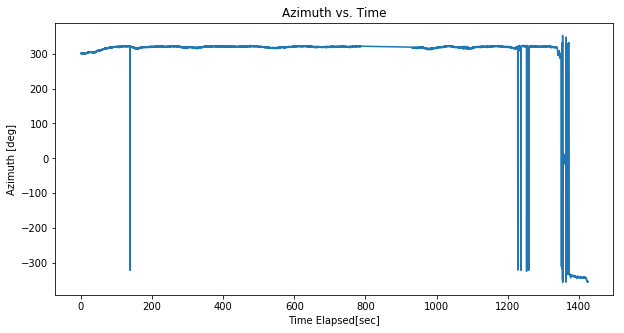

In [15]:
# Plot Smartfin data
heading_azi_plot = plt.figure(figsize=(10,5))
azi_plot = heading_azi_plot.add_subplot(111)
azi_plot.plot(time_e_array, heading_azimuth)
azi_plot.set_title("Azimuth vs. Time")
azi_plot.set_xlabel("Time Elapsed[sec]")
azi_plot.set_ylabel("Azimuth [deg]")

print()
# Get buoy data from CDIP website
# Link: https://cdip.ucsd.edu/themes/?d2=p70:s:201&zoom=auto&pub_set=public&regions=california_south&tz=UTC&units=standard

<img src='./CDIPdirection.png'>

<img src='./AverageDirection.png'>

In [16]:
# Calculate average heading using my own graph
total_sum = 0
for i in heading_azimuth:
    total_sum += i

my_average = total_sum/len(heading_azimuth)
expected_average = 282.41

print("My calculated average heading (deg) is:")
print(my_average)

print("\nThe expected heading (deg) is:")
print(expected_average)

# Calculate error in findings
error_percent = (my_average - expected_average) / expected_average
print("\nThe percentage error in my model is:")
print(error_percent)

My calculated average heading (deg) is:
286.95832871711616

The expected heading (deg) is:
282.41

The percentage error in my model is:
0.016105409571602048


# With error of just 1.61%, model is highly accurate!